In [1]:
%matplotlib inline
import pandas as pd
import os
import re
from Bio import SeqIO
import pysam
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SearchIO
from pybedtools import BedTool
import numpy as np
import pybedtools
import multiprocessing
import re
import time
import matplotlib.pyplot as plt

/home/benjamin/anaconda3/lib/python3.5/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


This notebook is a restart of the TE_filtering_and_summary_p_contigs notebook. It is aimed at adding two columns to the TE summary dataframe.
* age of TE
* classification

The age should be plotted out by superfamily and the new dataframe provided for the paper as well.

In [2]:
def ID_filter_gff(_feature, _id):
    """
    This filter parses out the top level id form the 9th gff column form a REPET gff file.
    It has a specific search pattern for each feature type in column 2.
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    This function expects that the variable genome either ends with p_ctg or h_ctg and adapts the
    search pattern accordingly.
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':
        if genome.endswith('p_ctg'):
            TE_pattern = r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([^;| ]*)'
        elif genome.endswith('h_ctg'):
            TE_pattern = r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_[0-9]*_([^;| ]*)'
        TE_prog = re.compile(TE_pattern)
        TE_match = TE_prog.search(_id)

        try:
            return TE_match.group(1)
        except AttributeError:
            print(_id)

    if _type == 'REPET_SSRs':
        if genome.endswith('p_ctg'):
            SSR_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*)'
        elif genome.endswith('h_ctg'):
            SSR_pattern = 'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_[0-9]*_([A-Z,a-z,0-9,-]*)'
        SSR_prog = re.compile(SSR_pattern)
        SSR_match = SSR_prog.search(_id)
        return SSR_match.group(1)
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        if genome.endswith('p_ctg'):
            blast_prog = re.compile(r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_([^;| ]*)')
        elif genome.endswith('h_ctg'):
             blast_prog = re.compile(r'ID=[A-Z,a-z,0-9,-]*_[A-Z,a-z,0-9]*_[0-9]*_[0-9]*_([^;| ]*)')
        #blast_prog = re.compile(blast_pattern)
        blast_match = blast_prog.search(_id)
        return blast_match.group(1)


In [3]:
def blast_hit_gff(_feature, _row8, _id):
    """
    This filter parses the blast hit for REPET_TEs from the new 'ID' column. If no blast hit available returns Pastec ids.
    If the result is blast already the value is simple parse the blast hit.
    SSRs also get SSR
    !!!Requires the three_letter_dict to be defined previously.!!!
    _type is defined by the feature '_'.join(feature.split("_")[-2:])
    """
    _type = '_'.join(_feature.split("_")[-2:])
    if _type == 'REPET_TEs':
        #split the pastec_cat into the first three letter code
        #the spliting of the 'ID' column needs to be done differently depending on the h or p contigs.
        #h contigs contain one additional '_' in the contig id

        pastec_cat = _id.split('_')[0]
        if 'TE_BLR' in _row8:
            #hit_list = [x.split(';')[3] for x in _row8]
            blast_hit_pattern = r'TE_BLR\w*: (\S*)[ |;]'
            blast_hit_prog = re.compile(blast_hit_pattern)
            TE_match = blast_hit_prog.findall(_row8)
            first_sub_class = ':'.join(TE_match[0][:-1].split(':')[1:])
            if len([x for x in TE_match if first_sub_class in x]) == len(TE_match):
                if ';' in first_sub_class:
                    return first_sub_class.split(';')[0]
                else:
                    return first_sub_class
#fix this here to include the there letter code of the first bit of the ID similar to the blast hits
#e.g. ClassI:?:? and so on. a dict might be the easiest here.
            
            else:
                return three_letter_dict[pastec_cat]
        else:
            return three_letter_dict[pastec_cat]
    if _type == 'REPET_SSRs':
        return 'SSR'
        

        return SSR_match.group(1)
    if _type == 'REPET_tblastx' or _type == 'REPET_blastx':
        return ':'.join(_id.split(':')[1:])

In [4]:
def TE_classification_filter(_id, level = 0):
    """
    This function pulls out the class == level1, Order == level2, Superfamily == leve3.
    If SSR or noCat return these values.
    
    """
    if len(_id.split(':')) == 1:
        return _id
    if level == 0:
        _class = _id.split(':')[0]
        if _class == 'ClassI':
            return 'Retrotransposon'
        if _class == 'ClassII':
            return 'DNA_transposon'
    elif level == 1:
        _order = _id.split(':')[1]
        if _order == '?':
            return 'noCat'
        else:
            return _order
    elif level == 2:
        _superfamily = _id.split(':')[2]
        if _superfamily == '?':
            return 'noCat'
        else:
            return _superfamily
    else:
        print('Something wrong! Check if level is 0, 1 or 2')

#### This needs to be updated here according to genome (either p_ctg or h_ctg)

In [5]:
source_dir = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly'
genome = 'Pst_104E_v12_p_ctg'
out_dir = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/revision/TE_dating'

In [6]:
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [7]:
#remove all commenting lines from the initial repet file
!grep -v "^#" {source_dir}/{genome}.REPET.gff > {out_dir}/{genome}.REPET.gff

In [8]:
p_repet_gff = pd.read_csv(out_dir+'/'+genome+'.REPET.gff', sep='\t', header = None)

#### This needs to be updated here according to genome

In [9]:
#This needs to be updated here according to genome
TE_post_analysis_p = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/REPET/Pst79_p/Pst79_p_full_annotate/postanalysis/'

In [10]:
TE_post_analysis_p_header = 'TE      length  covg    frags   fullLgthFrags   copies  fullLgthCopies  meanId  sdId    minId   q25Id   medId   q75Id   maxId   meanLgth        sdLgth  minLgth q25Lgth medLgth q75Lgth maxLgth meanLgthPerc    sdLgthPerc      minLgthPerc  q25LgthPerc     medLgthPerc     q75LgthPerc     maxLgthPerc'.split(' ')

In [11]:
TE_post_analysis_p_header = [x for x in TE_post_analysis_p_header if x != '']

In [12]:
!ls {TE_post_analysis_p}

blastclust.log
error.log
Pst79p_anno_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab
Pst79p_anno_chr_allTEs_nr_noSSR_join_path.globalAnnotStatsPerTE.txt
Pst79p_anno_chr_allTEs_path.annotStatsPerCluster.tab
Pst79p_anno_chr_allTEs_path.annotStatsPerTE.tab
Pst79p_anno_chr_allTEs_path.globalAnnotStatsPerTE.txt
Pst79p_anno_chr_bankBLRtx_path.annotStatsPerTE.tab
Pst79p_anno_chr_bankBLRtx_path.globalAnnotStatsPerTE.txt
Pst79p_anno_chr_bankBLRx_path.annotStatsPerTE.tab
Pst79p_anno_chr_bankBLRx_path.globalAnnotStatsPerTE.txt
Pst79p_anno_refTEs.fa
Pst79p_anno_refTEs.fa_blastclust.classifStatsPerCluster.tab
Pst79p_anno_refTEs.fa_blastclust.globalStatsPerCluster.txt
Pst79p_anno_refTEs.fa_blastclust.statsPerCluster.tab
Pst79p_anno_refTEs.fa_blastclust.tab


#### This needs to be updated here according to genome

In [13]:
#now get the summary of allTEs == TEs specificaly identified by TEdenovo from REPET
p_repet_summary_denovoTEs_df = pd.read_csv(TE_post_analysis_p+'/'+'Pst79p_anno_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab' ,\
                                names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

#now get in the summary of all bankBLRx TEs == TEs identified by repbase20.05_ntSeq_cleaned_TE
p_repet_summary_nt_repbase_df = pd.read_csv(\
    os.path.join(TE_post_analysis_p, 'Pst79p_anno_chr_bankBLRx_path.annotStatsPerTE.tab') ,\
    names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

#now get in the summary of all bankBLRtx TEs == TEs identified by repbase20.05_aaSeq_cleaned_TE
p_repet_summary_aa_repbase_df = pd.read_csv(\
    os.path.join(TE_post_analysis_p, 'Pst79p_anno_chr_bankBLRtx_path.annotStatsPerTE.tab') ,\
    names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )

In [14]:
#generate a df that contains all TEs: TEdenovo, blastx, blastn
p_repet_summary_all_TEs_df = pd.concat([p_repet_summary_denovoTEs_df ,p_repet_summary_nt_repbase_df,\
                                       p_repet_summary_aa_repbase_df], axis=0)
#subset to remove every TE wo hit and all potential host genes
p_repet_summary_all_TEs_df =  p_repet_summary_all_TEs_df[p_repet_summary_all_TEs_df.copies > 0]
p_repet_summary_all_TEs_df =  p_repet_summary_all_TEs_df[\
                               ~p_repet_summary_all_TEs_df.TE.str.startswith("Potential")]

In [15]:
#this needs to be fixed up to pick the proper summary table
p_repet_summary_df = pd.read_csv(TE_post_analysis_p+'/'+'Pst79p_anno_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab' ,\
                                names = TE_post_analysis_p_header, header=None, sep='\t', skiprows=1 )
#


#check if I can filter the tab files for removing all TEs that are on the 2000 plus contigs
#remove tRNAs TEs with infernal

p_repet_summary_df['Code'] = p_repet_summary_df['TE'].apply(lambda x: x.split('_')[0])

code_keys = p_repet_summary_df['Code'].unique()

code_keys.sort()

code_long = ['DNA_transposon Helitron', 'DNA_transposon Helitron', 'DNA_transposon Helitron', 'DNA_transposon Maverick',\
            'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon TIR', 'DNA_transposon noCat',\
             'DNA_transposon MITE','DNA_transposon MITE', 'Potential Host Gene', 'Retrotransposon LINE', 'Retrotransposon LINE',\
             'Retrotransposon LINE','Retrotransposon LTR','Retrotransposon LTR', 'Retrotransposon LTR', 'Retrotransposon LTR', 'Retrotransposon PLE', \
             'Retrotransposon SINE',  'Retrotransposon SINE', 'Retrotransposon noCat', 'Retrotransposon LARD',\
             'Retrotransposon LARD', 'Retrotransposon TRIM', 'Retrotransposon TRIM', 'Retrotransposon noCat',  \
             'Retrotransposon DIRS','Retrotransposon DIRS','Retrotransposon DIRS','Retrotransposon DIRS',\
             'noCat', 'noCat']
if len(code_keys) != len(code_long):
    print('Check the code_long list, because different length of keys and values!\n\n')
else:
    print('Check the code dict anyway')
code_dict = dict(zip(code_keys, code_long))
print(code_dict)

Check the code dict anyway
{'DTX-incomp-chim': 'DNA_transposon TIR', 'RSX-incomp': 'Retrotransposon SINE', 'DXX-MITE': 'DNA_transposon MITE', 'DXX-MITE-chim': 'DNA_transposon MITE', 'DHX-incomp': 'DNA_transposon Helitron', 'RXX-TRIM-chim': 'Retrotransposon TRIM', 'RLX-comp-chim': 'Retrotransposon LTR', 'RLX-comp': 'Retrotransposon LTR', 'RXX-chim': 'Retrotransposon noCat', 'RIX-incomp': 'Retrotransposon LINE', 'RIX-comp': 'Retrotransposon LINE', 'PotentialHostGene': 'Potential Host Gene', 'RYX-comp': 'Retrotransposon DIRS', 'RXX-LARD-chim': 'Retrotransposon LARD', 'RLX-incomp-chim': 'Retrotransposon LTR', 'XXX-chim': 'noCat', 'DTX-comp': 'DNA_transposon TIR', 'DHX-incomp-chim': 'DNA_transposon Helitron', 'RPX-incomp-chim': 'Retrotransposon PLE', 'noCat': 'noCat', 'DHX-comp': 'DNA_transposon Helitron', 'RYX-incomp-chim': 'Retrotransposon DIRS', 'RXX-LARD': 'Retrotransposon LARD', 'DTX-comp-chim': 'DNA_transposon TIR', 'DTX-incomp': 'DNA_transposon TIR', 'RXX': 'Retrotransposon noCat', '

In [16]:
p_repet_summary_df['Code long'] = p_repet_summary_df['Code'].apply(lambda x: code_dict[x])
p_repet_summary_sum_df = pd.pivot_table(p_repet_summary_df, values=['covg', 'copies'], index='Code long', aggfunc=np.sum)
p_repet_summary_mean_df = pd.pivot_table(p_repet_summary_df, values='length', index='Code long', aggfunc=np.mean)
pd.concat([p_repet_summary_sum_df,p_repet_summary_mean_df], axis=1 )

,copies,covg,length
Code long,,,
DNA_transposon Helitron,1075,817566,2989.764706
DNA_transposon MITE,3789,886304,490.240741
DNA_transposon Maverick,268,345406,8562.666667
DNA_transposon TIR,19166,12711595,4020.474359
DNA_transposon noCat,5286,2376456,3034.734513
Potential Host Gene,1372,1375304,6120.490566
Retrotransposon DIRS,1337,1049299,6874.526316
Retrotransposon LARD,10752,4947564,5407.736111
Retrotransposon LINE,323,237992,4446.625000


#### This needs to be updated here according to genome

In [17]:
#now filter the gff dataframe to delete all the high coverage contigs
#This might would have to be fixed as well. If we don't delete it as files should be already filtered
contigs_smaller_2000 = pd.read_csv('/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/032017_assembly/pcontig_smaller_2000.txt',\
                                  header=None)[0].tolist()

p_repet_gff = pd.read_csv(out_dir+'/'+genome+'.REPET.gff', sep='\t', header = None)

p_repet_gff_filtered = p_repet_gff[p_repet_gff[0].isin(contigs_smaller_2000)].reset_index(drop=True)

In [18]:
#filter out potential host genes
p_repet_gff_filtered = p_repet_gff_filtered[~p_repet_gff_filtered[8].str.contains("Potential")]

In [19]:
p_repet_gff_filtered['ID'] = p_repet_gff_filtered.apply(lambda row: ID_filter_gff(row[1], row[8]), axis=1)

In [20]:
#re-generate the code dict using the gff ID as Code keys


code_keys_gff = p_repet_gff_filtered[p_repet_gff_filtered[1].str.contains('REPET_TE')]['ID'].unique()

code_keys_gff = list({x.split('_')[0] for x in code_keys_gff})

code_keys_gff.sort()

#remove Potential host genes from long code list as those were filtered out previously.
code_long.remove('Potential Host Gene')

if len(code_keys_gff) != len(code_long):
    print("Go and check something is wrong at the code key stage!")

code_dict = dict(zip(code_keys_gff, code_long))

In [21]:
three_letter_code = list({x for x in code_keys_gff})

three_letter_code.sort()

three_letter_values = []
for x in three_letter_code:
    if 'MITE' in x:
        _value = "ClassII:MITE:?"
        three_letter_values.append(_value)
        continue
    if 'LARD' in x:
        _value = 'ClassI:LARD:?'
        three_letter_values.append(_value)
        continue
    if 'TRIM' in x:
        _value = 'ClassI:TRIM:?'
        three_letter_values.append(_value)
        continue
    _value =''
    if x[0] == 'D':
        _value = _value + 'ClassII:'
    if x[0] == 'R':
        _value = _value + 'ClassI:'
    if x[0] != 'D' and x[0] != 'R':
        _value = 'noCat'
        three_letter_values.append(_value)
        continue
    if x[1] == 'T':
        _value = _value + 'TIR:?'
    if x[1] == 'H':
        _value = _value + 'Helitron:?'
    if x[1] == 'M':
        _value = _value + 'Maverick:?'
    if x[0:2] == 'DY':
        _value = _value + ':Crypton:?'
    if x[1] == 'X':
        _value = _value + '?:?'
    if x[1] == 'I':
        _value = _value + 'LINE:?'
    if x[1] == 'L':
        _value = _value + 'LTR:?'
    if x[1] == 'P':
        _value = _value + 'Penelope:?'
    if x[1] == 'S':
        _value = _value + 'SINE:?'
    if x[0:2] == 'RY':
        _value = _value + 'DIRS:?'    
    three_letter_values.append(_value)

if len(three_letter_code) == len(three_letter_values):
    print("Aas")
    three_letter_dict = dict(zip(three_letter_code, three_letter_values))

Aas


In [22]:
p_repet_gff_filtered['Class:Order:Superfamily'] = p_repet_gff_filtered.apply(lambda row: blast_hit_gff(row[1], row[8], row['ID']), axis=1)

In [23]:
#generate a dict that can be used to rename the Class:Order:Superfamily column considering that partial matches ([2] == match_part) might contain different
#IDs even though they are the same TE only partial.
_tmp_subset = p_repet_gff_filtered[~p_repet_gff_filtered[1].str.contains('SSR')].loc[:, 'ID':].sort_values(by=['ID','Class:Order:Superfamily'])\
.drop_duplicates(subset='ID', keep ='last')

TE_COS_dict = dict(zip(_tmp_subset.loc[:, 'ID'], _tmp_subset.loc[:, 'Class:Order:Superfamily' ]))

_tmp_subset = p_repet_gff_filtered[p_repet_gff_filtered[1].str.contains('SSR')].loc[:, 'ID':].sort_values(by=['ID','Class:Order:Superfamily'])\
.drop_duplicates(subset='ID', keep ='last')

_tmp_dict = dict(zip(_tmp_subset.loc[:, 'ID'], _tmp_subset.loc[:, 'Class:Order:Superfamily' ]))

TE_COS_dict.update(_tmp_dict)
#remove all backslashes from the values as this will conflict with the output later on
for x in TE_COS_dict.keys():
    if '/' in TE_COS_dict[x]:
        value = TE_COS_dict[x]
        print(value)
        TE_COS_dict[x] = value.replace('/','_')
        print(TE_COS_dict[x])

ClassII:?:Ginger2/TDD
ClassII:?:Ginger2_TDD


In [24]:
#drop zeros from p_repet_summary_df
p_repet_summary_df = p_repet_summary_df[p_repet_summary_df.copies > 0]

In [25]:
#remove Potential host genes
p_repet_summary_df = p_repet_summary_df[~p_repet_summary_df.TE.str.startswith("Potential")]

In [26]:
p_repet_summary_df["COS"] = p_repet_summary_df["TE"].apply(lambda x: TE_COS_dict[x])

In [27]:
p_repet_summary_df.groupby("COS")["covg"].sum()

COS
ClassI:?:?                      77923
ClassI:DIRS:?                    5230
ClassI:DIRS:DIRS               411921
ClassI:LARD:?                 2580686
ClassI:LINE:?                    4187
ClassI:LINE:I                  207662
ClassI:LINE:Jockey               9239
ClassI:LTR:?                  1660264
ClassI:LTR:Copia              4399303
ClassI:LTR:Gypsy             10817418
ClassI:LTR:Retrovirus           18586
ClassI:Penelope:?               41843
ClassI:SINE:?                   31138
ClassI:TRIM:?                  183085
ClassII:?:?                   4053567
ClassII:?:Academ               267214
ClassII:Helitron:?             563604
ClassII:Helitron:Helitron      253962
ClassII:MITE:?                 886304
ClassII:Maverick:?             324099
ClassII:Maverick:Maverick       21307
ClassII:TIR:?                 3786988
ClassII:TIR:CACTA             1092698
ClassII:TIR:MuDR              1506387
ClassII:TIR:P                   53627
ClassII:TIR:PIF-Harbinger     1816676
ClassII:

In [28]:
set(p_repet_gff_filtered['Class:Order:Superfamily'].unique()) \
    - set(p_repet_summary_df["COS"].unique())

{'ClassI:LINE:L1',
 'ClassI:LINE:R2',
 'ClassI:LINE:RTE',
 'ClassI:LTR:Bel-Pao',
 'ClassI:LTR:ERV',
 'ClassI:PLE:Penelope',
 'ClassII:?:Ginger1',
 'ClassII:?:Ginger2/TDD',
 'ClassII:?:Kolobok',
 'ClassII:?:Sola',
 'ClassII:Crypton:Crypton',
 'ClassII:TIR:PiggyBac',
 'ClassII:TIR:Transib',
 'SSR'}

In [29]:
p_repet_summary_all_TEs_df["COS"] = p_repet_summary_all_TEs_df["TE"].apply(lambda x: TE_COS_dict[x])

In [30]:
set(p_repet_gff_filtered['Class:Order:Superfamily'].unique()) \
    - set(p_repet_summary_all_TEs_df["COS"].unique())

{'ClassII:?:Ginger2/TDD', 'SSR'}

In [31]:
#using the formula T=D/t in arXiv:1209.0176 [q-bio] to approximate TE age
# where D = (100-meanId)/100 and 
# t the substitution rate per site per year
# generations per year are estimate at 15 10.1111/j.1365-294X.2007.03513.x
# estimate of subsitution rate per year = 2 * 10-9 10.1093/oxfordjournals.molbev.a004056 and
# 10.1016/j.fbr.2010.03.001
p_repet_summary_all_TEs_df['TE_age_Mya'] = (((100-p_repet_summary_all_TEs_df.meanId)/100)\
                                        /(2*10**-9))/10**6
p_repet_summary_all_TEs_df['TE_age'] = (((100-p_repet_summary_all_TEs_df.meanId)/100)\
                                        /(2*10**-9))
p_repet_summary_all_TEs_df = p_repet_summary_all_TEs_df[p_repet_summary_all_TEs_df.copies > 5]

In [32]:
p_repet_summary_all_TEs_df_ClassI = p_repet_summary_all_TEs_df[\
                                    p_repet_summary_all_TEs_df.COS.str.startswith('ClassI:')]
p_repet_summary_all_TEs_df_ClassII = p_repet_summary_all_TEs_df[\
                                    p_repet_summary_all_TEs_df.COS.str.startswith('ClassII:')]

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
#histogram of 
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
label_config_x = {'fontsize'            : 'large',
      'verticalalignment'   : 'top',
      'horizontalalignment' : 'center'
      }
label_config_y = {'fontsize'            : 'large',
      'verticalalignment'   : 'bottom',
      'horizontalalignment' : 'center'
      }
matplotlib.rc('font', **font)

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


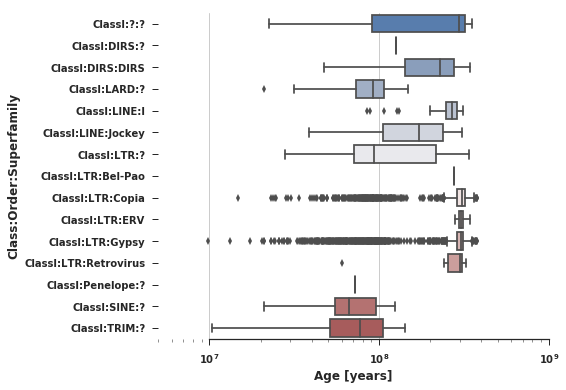

In [52]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

p_repet_summary_all_TEs_df_ClassI.sort_values(by='COS', inplace=True)
sns.boxplot(x='TE_age', y='COS', data=p_repet_summary_all_TEs_df_ClassI,palette="vlag")

plt.xlim(5*10**6, 10**9)
plt.ylabel("Class:Order:Superfamily",fontsize = 12, weight= 'bold')
plt.xlabel("Age [years]",fontsize = 12, weight= 'bold')

ax.xaxis.grid(True)
sns.despine(trim=True, left=True)
out_fn = os.path.join(out_dir, 'ClassI_age.png')
f.savefig(out_fn, dpi=600,bbox_inches="tight")

/home/benjamin/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


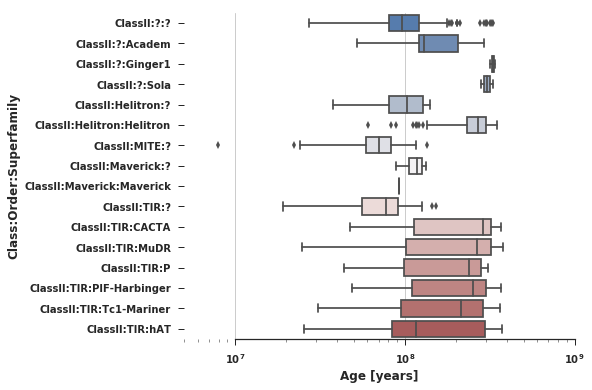

In [53]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

p_repet_summary_all_TEs_df_ClassII.sort_values(by='COS', inplace=True)
sns.boxplot(x='TE_age', y='COS', data=p_repet_summary_all_TEs_df_ClassII,palette="vlag")

plt.xlim(5*10**6, 10**9)
plt.ylabel("Class:Order:Superfamily",fontsize = 12, weight= 'bold')
plt.xlabel("Age [years]",fontsize = 12, weight= 'bold')

ax.xaxis.grid(True)
sns.despine(trim=True, left=True)

out_fn = os.path.join(out_dir, 'ClassII_age.png')
f.savefig(out_fn, dpi=600,bbox_inches="tight")

In [37]:
sub_df_young_many = p_repet_summary_all_TEs_df[(p_repet_summary_all_TEs_df.copies > 50) &( p_repet_summary_all_TEs_df.TE_age_Mya < 100)]

In [38]:
sub_df_young_many_by_COS_sum = sub_df_young_many.groupby('COS').sum()

In [39]:
sub_df_young_many_by_COS_sum['Class'] = 'noCat'
sub_df_young_many_by_COS_sum["Index"] = sub_df_young_many_by_COS_sum.index
sub_df_young_many_by_COS_sum['Order'] = 'noCat'
sub_df_young_many_by_COS_sum['Class:Order'] = 'noCat'

In [40]:
#generate Class column or noCat
sub_df_young_many_by_COS_sum.loc[\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].index\
                                 , "Class"] =\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].Index.apply\
(lambda x: x.split(':')[0])

#generate Order column or noCat
sub_df_young_many_by_COS_sum.loc[\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].index\
                                 , "Order"] =\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].Index.apply\
(lambda x: x.split(':')[1])


#generate Class order column
sub_df_young_many_by_COS_sum.loc[\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')].index\
                                 , "Class:Order"] =\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')]['Class']\
+ ':' +\
sub_df_young_many_by_COS_sum[sub_df_young_many_by_COS_sum.index.str.contains(':')]['Order']


In [41]:
sub_df_young_many_by_COS_sum.head()

,length,covg,frags,fullLgthFrags,copies,fullLgthCopies,meanId,sdId,minId,q25Id,...,q25LgthPerc,medLgthPerc,q75LgthPerc,maxLgthPerc,TE_age_Mya,TE_age,Class,Index,Order,Class:Order
COS,,,,,,,,,,,,,,,,,,,,,
ClassI:LARD:?,75597,384719,970,10,879,10,830.38,88.38,625.10,766.60,...,9.44,19.96,59.27,1000.00,848.10,8.481000e+08,ClassI,ClassI:LARD:?,LARD,ClassI:LARD
ClassI:LINE:I,15043,47936,176,1,164,1,82.96,7.59,56.50,78.00,...,0.70,1.02,1.44,100.00,85.20,8.520000e+07,ClassI,ClassI:LINE:I,LINE,ClassI:LINE
ClassI:LTR:?,125116,699897,1944,248,1673,268,1341.04,134.64,970.15,1253.96,...,279.60,337.27,385.54,1638.73,1294.80,1.294800e+09,ClassI,ClassI:LTR:?,LTR,ClassI:LTR
ClassI:LTR:Copia,174682,872398,1901,25,1712,26,1766.35,182.55,1334.24,1645.93,...,49.25,89.93,179.44,2100.22,1668.25,1.668250e+09,ClassI,ClassI:LTR:Copia,LTR,ClassI:LTR
ClassI:LTR:Gypsy,368354,2230888,3767,50,3178,49,3151.79,334.64,2304.02,2949.23,...,140.72,299.04,587.57,3903.99,2741.05,2.741050e+09,ClassI,ClassI:LTR:Gypsy,LTR,ClassI:LTR


In [42]:
#get color column sorted
colors = sns.color_palette('cubehelix', n_colors=\
                           len(sub_df_young_many_by_COS_sum['Class:Order'].unique()))
color_dict = dict(zip(sub_df_young_many_by_COS_sum['Class:Order'].unique(), colors))


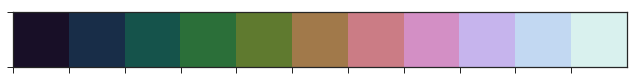

In [43]:
sns.palplot(colors)

In [44]:
sub_df_young_many_by_COS_sum['color'] = sub_df_young_many_by_COS_sum['Class:Order'].apply(\
        lambda x: color_dict[x])
color_index_dict = dict(zip(sub_df_young_many_by_COS_sum.Index, sub_df_young_many_by_COS_sum.color))

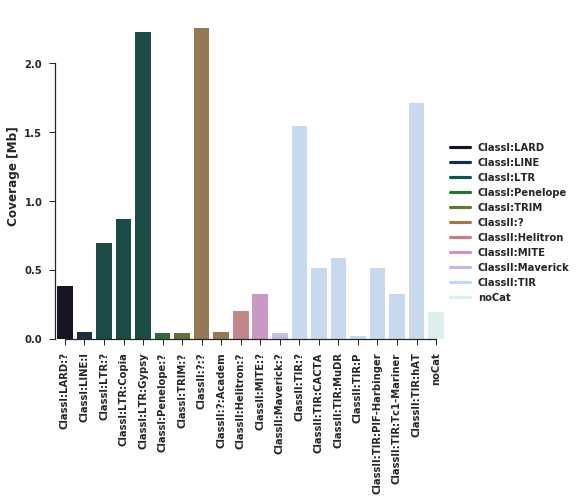

In [51]:
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
sns.barplot(sub_df_young_many_by_COS_sum.index, sub_df_young_many_by_COS_sum.covg/10**6,\
           palette=color_index_dict)

plt.ylabel("Coverage [Mb]",fontsize = 12, weight= 'bold')
plt.xlabel("",fontsize = 12, weight= 'bold'"")
sns.despine(trim=True)

#change the colors of the legend
key_list = list(color_dict.keys())
key_list.sort()
plt.legend(key_list, loc=(1, 0.1))
leg = ax.get_legend()
for (x,y) in zip(key_list, leg.legendHandles):
    y.set_color(color_dict[x])
    


for l in ax.get_xticklabels():
    l.set_rotation(90)

out_fn = os.path.join(out_dir, 'TEs_young_and_plenty.png')
f.savefig(out_fn, dpi=600, bbox_inches="tight")

In [46]:
#now save out REPET summary dataframe
fn = os.path.join(out_dir, "Pst_104E_REPET_summary_all_TEs.df")
p_repet_summary_all_TEs_df.to_csv(fn, sep='\t', index= None)